## Paper Replication

This paper will replicate the data pre-processing steps taken within the research paper, [Understanding the Factors That Impact the Popularity of GitHub Repositories](https://ieeexplore.ieee.org/abstract/document/7816479).

* **Objective:** To verify and challenge the claim that there is no correlation between the stars a repository receives and its age, by identifying any potential small, but positive correlations.
* **Data Collection:** Ensuring the dataset includes a wide range of repositories with varying ages and star counts to maintain a more representative sample of GitHub repositories.
* **Data Pre-processing:** Implementing rigorous data cleaning and validation steps to ensure accuracy and reliability of the data used for analysis.
* **Statistical Methods:** Utilizing robust statistical techniques to detect even slight correlations that may exist between repository age and number of stars.
* **Comparative Analysis:** Directly comparing findings with those reported in the original paper to highlight any discrepancies and discuss potential reasons for differences in outcomes.
* **Hypothesis Testing:** Formulating and testing a hypothesis that a small but significant correlation exists, contrary to the original paper's findings.
* **Significance Testing:** Conducting tests to confirm the statistical significance of the observed correlation, thereby strengthening the argument against the original findings.

These steps are intended to provide a comprehensive approach to replicate and critically evaluate the findings of the original research, focusing specifically on the relationship between repository age and popularity as measured by stars.


Import Packages

In [1]:
import pandas as pd
import json
import ijson
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import shap
import statsmodels.api as sm
from IPython.display import display
from sklearn.model_selection import train_test_split
from matplotlib.backends.backend_pdf import PdfPages

Read CSV from second dataset.

In [2]:
df_filtered = pd.read_csv('./datasets/second_dataset.csv')

### Gather top 2,500 repositories by star count.

In [6]:
# Sort the DataFrame by 'stars' in descending order
df_sorted = df_filtered.sort_values(by='stars', ascending=False)

# Select the top 2500 entries
top_2500_repos = df_sorted.head(2500)

### Convert repository age to weeks instead of years.
* Multiply age by 365.25, then divide by appropriate number of weeks.

In [8]:
# Calculate the age in days by multiplying 'age' by 365.25
top_2500_repos.loc[:, 'age_days'] = top_2500_repos['age'] * 365.25

# Convert days to weeks by dividing 'age_days' by 7
top_2500_repos.loc[:, 'age_weeks'] = top_2500_repos['age_days'] / 7

# Display the updated DataFrame to verify changes
print(top_2500_repos[['age', 'age_days', 'age_weeks']])

        age   age_days   age_weeks
0      8.65  3159.4125  451.344643
1      9.85  3597.7125  513.958929
2      4.22  1541.3550  220.193571
3      9.10  3323.7750  474.825000
4      7.17  2618.8425  374.120357
...     ...        ...         ...
2495   9.97  3641.5425  520.220357
2496  12.93  4722.6825  674.668929
2497   2.21   807.2025  115.314643
2498   9.87  3605.0175  515.002500
2499  12.83  4686.1575  669.451071

[2500 rows x 3 columns]


In [5]:
top_2500_repos

,owner,name,stars,forks,watchers,primaryLanguage,description,diskUsageKb,pullRequests,issues,defaultBranchCommitCount,age,age_days,age_weeks
0,freeCodeCamp,freeCodeCamp,371122,33158,8446,TypeScript,freeCodeCamp.org's open-source codebase and cu...,372202,33649,17010,33585.0,8.65,3159.4125,451.344643
1,EbookFoundation,free-programming-books,295895,56913,9733,NaN,:books: Freely available programming books,17038,8392,957,8386.0,9.85,3597.7125,513.958929
2,996icu,996.ICU,267804,21532,4242,NaN,Repo for counting stars and contributing. Pres...,187799,1962,0,3195.0,4.22,1541.3550,220.193571
3,sindresorhus,awesome,265809,26349,7549,NaN,😎 Awesome lists about all kinds of interesting...,1441,1943,331,1103.0,9.10,3323.7750,474.825000
4,jwasham,coding-interview-university,263430,69043,8604,NaN,A complete computer science study plan to beco...,20963,902,402,2372.0,7.17,2618.8425,374.120357
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3274582,xutianyi1999,mutsuki,5,3,1,Rust,Socks5/HTTP proxy server,93,0,1,34.0,2.16,788.9400,112.705714
3274583,dickwyn,cip-2021,5,0,2,NaN,My slides for Code in Place sections,13561,0,0,4.0,0.02,7.3050,1.043571
3274584,acend,terraform-training,5,1,4,HCL,NaN,2873,257,7,564.0,2.29,836.4225,119.488929
3274585,suryafaktaTV,suryaTVplay,5,2,1,NaN,All Channel,683,0,0,284.0,1.82,664.7550,94.965000


### More pre-processing:
* star counts are left untouched; no normalization metric
* filter out rows where age <= 0 (still possible for some reason)
* normalize data using logarithmic function
* remove outliers using 75/25 IQR

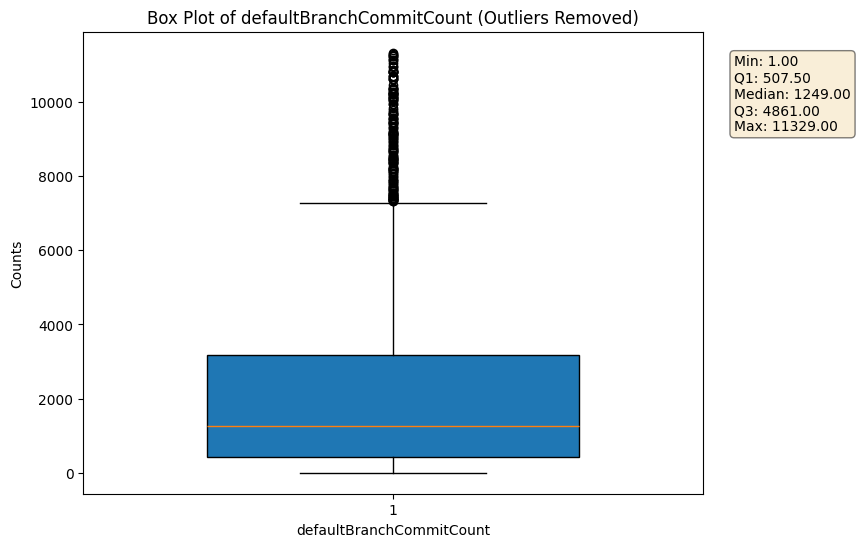

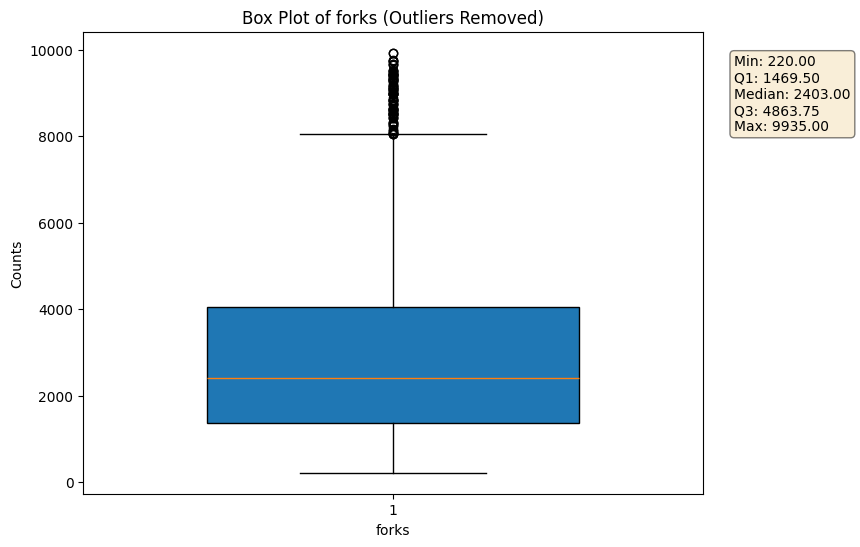

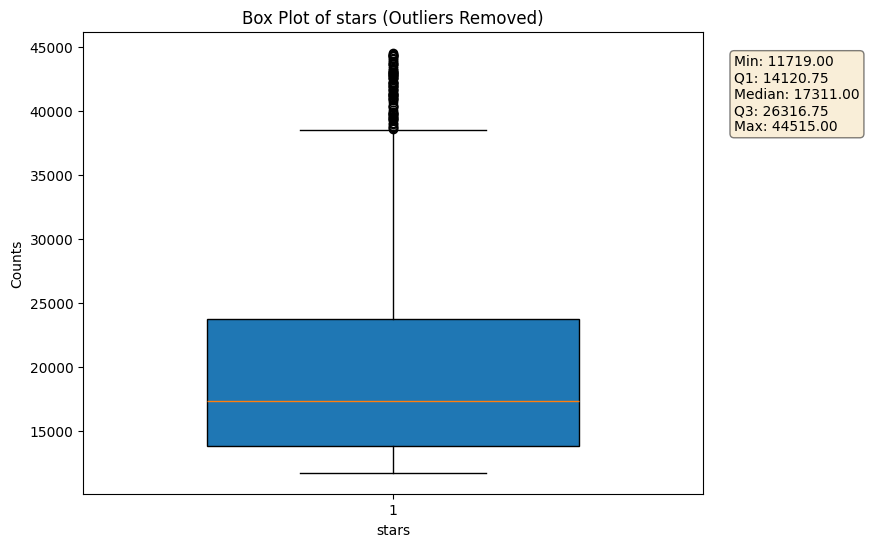

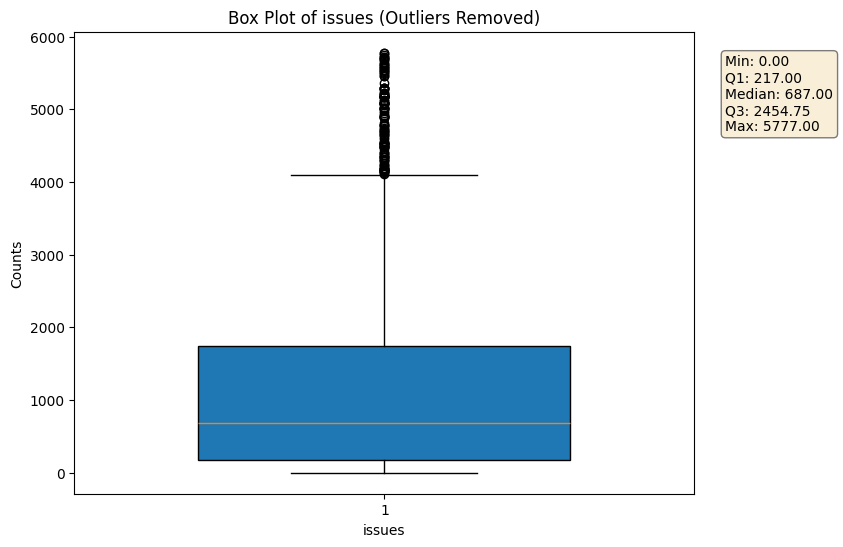

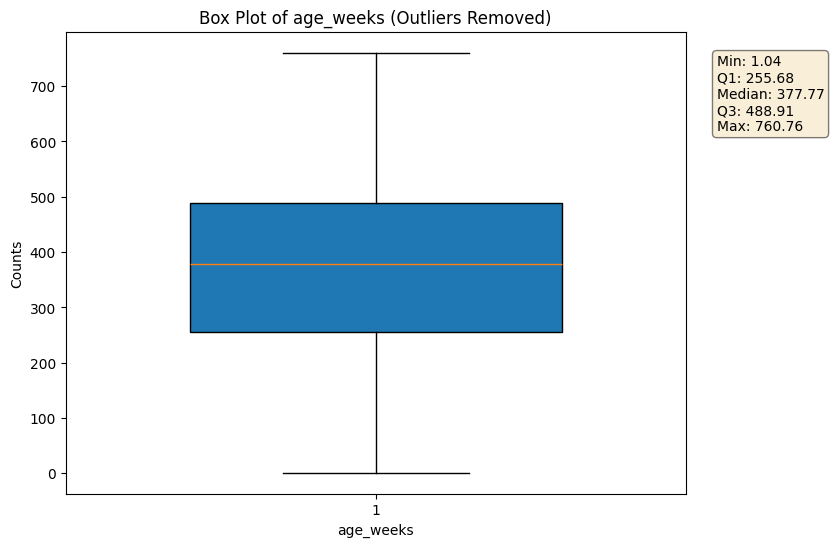

In [14]:
def remove_outliers_and_plot(df):
    # Define the columns for which you want to compute the metrics
    metrics = ['defaultBranchCommitCount', 'forks', 'stars', 'issues', 'age_weeks']

    for metric in metrics:
        Q1 = df[metric].quantile(0.25)
        Q3 = df[metric].quantile(0.75)
        IQR = Q3 - Q1

        # Define bounds for outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Filter out outliers
        filtered_df = df[(df[metric] >= lower_bound) & (df[metric] <= upper_bound)]

        # Generate box plot for the filtered data for each metric
        fig, ax = plt.subplots(figsize=(8, 6))
        bp = ax.boxplot(filtered_df[metric].dropna(), vert=True, widths=0.6, patch_artist=True)  # Ensuring vertical boxplot

        # Annotation text
        stats_text = (
            f'Min: {filtered_df[metric].min():.2f}\n'
            f'Q1: {Q1:.2f}\n'
            f'Median: {filtered_df[metric].median():.2f}\n'
            f'Q3: {Q3:.2f}\n'
            f'Max: {filtered_df[metric].max():.2f}'
        )
        
        # Place a text box in upper right in axes coords
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
        ax.text(1.05, 0.95, stats_text, transform=ax.transAxes, fontsize=10,
                verticalalignment='top', bbox=props)

        ax.set_title(f'Box Plot of {metric} (Outliers Removed)')
        ax.set_xlabel(metric)
        ax.set_ylabel('Counts')
        plt.show()

# df is your DataFrame loaded with repository data
remove_outliers_and_plot(top_2500_repos)

* The above figure shows the distribution of the age (in number of weeks), number of commits, number of stars, and number of forks for the 2,500 systems in the dataset.
* For age, the first, second, and third quartiles are **255.68**, **377.77**, and **488.91** weeks, respectively. 
* For number of commits, the first, second, and third quartiles are **507.50**, **1249**, and **4861** weeks, respectively. 
* For number of stars, the first, second, and third quartiles are **14120.75**, **17311**, and **26316.75** weeks, respectively.
* For number of forks, the first, second, and third quartiles are **1469.50**, **2403**, and **4863.75**, respectively.
* The systems in our dataset are therefore mature and have many commits and contributors, similar to the original paper.

### Scatterplots to visualize feature correlation

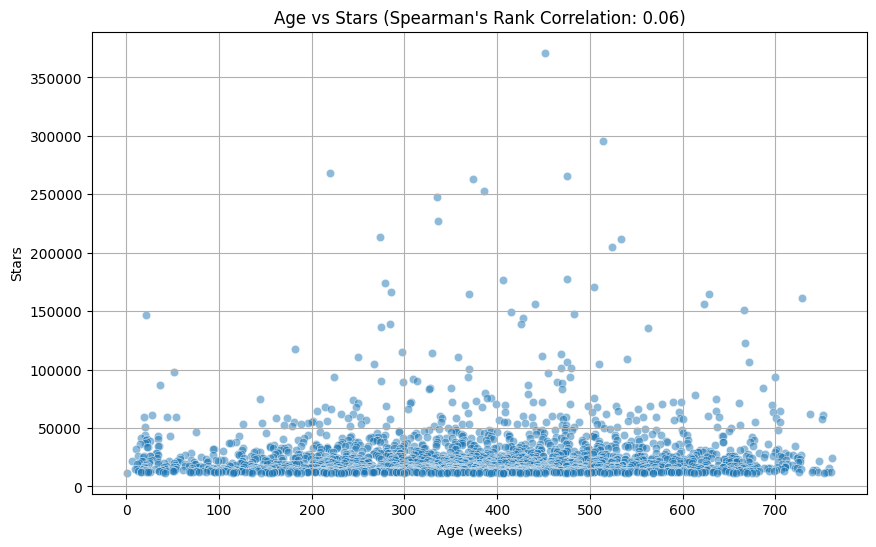

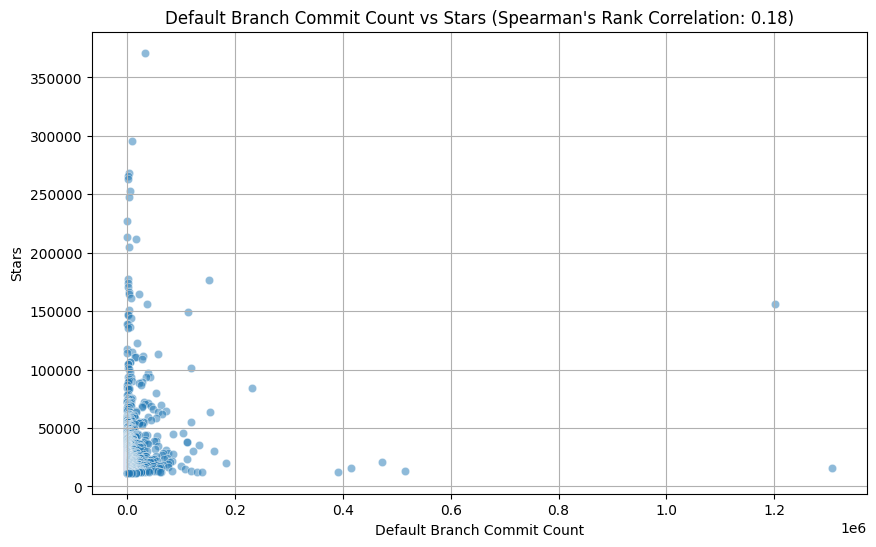

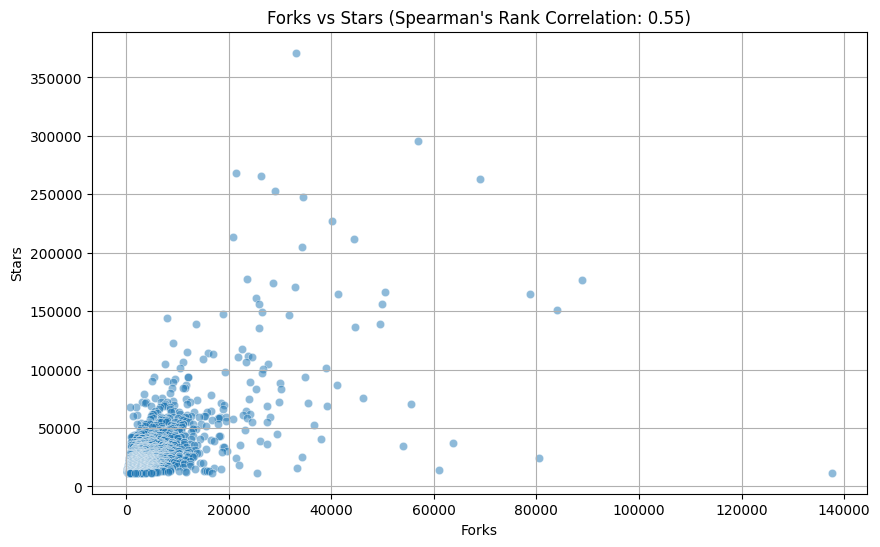

In [20]:
def generate_scatter_plots(df):
    # Plot configurations
    plot_configs = [
        {'x': 'age_weeks', 'y': 'stars', 'title': 'Age vs Stars', 'xlabel': 'Age (weeks)', 'ylabel': 'Stars'},
        {'x': 'defaultBranchCommitCount', 'y': 'stars', 'title': 'Default Branch Commit Count vs Stars', 'xlabel': 'Default Branch Commit Count', 'ylabel': 'Stars'},
        {'x': 'forks', 'y': 'stars', 'title': 'Forks vs Stars', 'xlabel': 'Forks', 'ylabel': 'Stars'}
    ]
    
    # Generate scatter plots for each configuration
    for config in plot_configs:
        # Calculate the Spearman's rank correlation coefficient
        correlation = df[[config['x'], config['y']]].corr(method='spearman').iloc[0, 1]
        
        plt.figure(figsize=(10, 6))
        plt.scatter(df[config['x']], df[config['y']], alpha=0.5, edgecolors='w', linewidths=0.5)
        plt.title(f"{config['title']} (Spearman's Rank Correlation: {correlation:.2f})")
        plt.xlabel(config['xlabel'])
        plt.ylabel(config['ylabel'])
        
        # Optional: Add correlation as an annotation instead
        # plt.annotate(f'Spearman's Rank Correlation: {correlation:.2f}', xy=(0.05, 0.95), xycoords='axes fraction',
        #              textcoords="axes fraction", ha='left', va='top', fontsize=10, bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='wheat', alpha=0.5))
        
        plt.grid(True)
        plt.show()

# Assuming top_2500_repos is your DataFrame loaded with repository data
generate_scatter_plots(top_2500_repos)

## **Conclusion**
* Upon calculating the scatterplots, our result goes against the research paper's claim of there being **no correlation** between the age of a repository and its star count, as our Spearman's correlation coefficient = 0.06.
* Note: the paper's method for removing outliers is not explicitly listed, which can be a contributing factor to conflicting results.